In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from statistics import mean

In [56]:
# raw data
raw = pd.read_csv('owid-energy-data.csv')

df = raw[raw['year']>1969]

#A list of all of the countries included and all of the features 
countries = list(df['country'].unique())
all_features = list(df)

## Data Preprocessing 

In [57]:
energyshares = ['country','year','fossil_share_energy','low_carbon_share_energy','biofuel_share_energy', 'coal_share_energy', 'gas_share_energy', 'hydro_share_energy', 'nuclear_share_elec', 'oil_share_energy', 'renewables_share_energy', 'solar_share_energy', 'wind_share_energy' ]
energyShare = raw[energyshares]
energyShare = energyShare[energyShare['year'] == 2020] # clustering for most recent year
#print(energyShare.isna().sum().sum()) # 1369 NaN values

energyShare[energyShare.isna().any(axis=1)] # 189 rows with NaN 

energyShare = energyShare.dropna() 
energyShare.reset_index(level=0, inplace=True)

#Remove rows that are not countries including 'World', 'Africa', 'Europe', 'CIS', 'OECD', 'Non OECD' etc. 
energyShare = energyShare.drop([0,7, 11, 12, 20, 22, 23, 32])
#remove categorical data for clustering 
data = energyShare.drop(columns =['index', 'country', 'year'])


## Model 1: K-Means Clustering with all dimensions

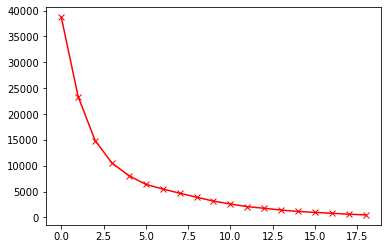

In [58]:
#KMeans for k=1-20 to determine best value for K using elbow method. 

scores = [] #list to store the inertia values for several values of K

for ii in range(1,20):
    kmeans = KMeans(n_clusters=ii)
    kmeans.fit(data)
    scores.append(kmeans.inertia_)
    
#Plotting using elbow rule - inertia vs K.
plt.plot(scores, '-rx')
plt.show()

In [59]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(data)
cluster_centroids = pd.DataFrame(kmeans_3.cluster_centers_, columns=data.columns)
cluster_centroids
energyShare['Three_Clusters'] = kmeans_3.predict(energyShare[energyshares[2:]])

kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(data)
cluster_centroids = pd.DataFrame(kmeans_5.cluster_centers_, columns=data.columns)
cluster_centroids
energyShare['Five_Clusters'] = kmeans_5.predict(energyShare[energyshares[2:]])

label3 = pd.DataFrame(energyShare['Three_Clusters'].value_counts())
label5 = pd.DataFrame(energyShare['Five_Clusters'].value_counts())

print("Distribution of predicted labels for 3 clusters:")
print(label3)
print( )
print("Distribution of predicted labels for 5 clusters:")
print(label5)

Distribution of predicted labels for 3 clusters:
   Three_Clusters
1              13
0               6
2               6

Distribution of predicted labels for 5 clusters:
   Five_Clusters
1              6
2              6
3              5
4              5
0              3


There are 11 dimensions, so the clusters can not be visualized, rather they can be viewed numerically. 

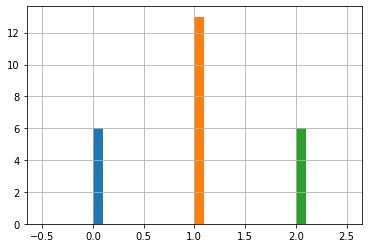

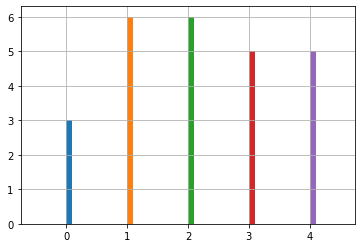

,fossil_share_energy,low_carbon_share_energy,biofuel_share_energy,coal_share_energy,gas_share_energy,hydro_share_energy,nuclear_share_elec,oil_share_energy,renewables_share_energy,solar_share_energy,wind_share_energy
0,89.308167,10.691833,0.758500,45.622333,15.416833,4.023833,2.111000,28.268833,9.729833,1.528500,2.279333
1,80.337000,19.663000,1.067077,8.127846,33.048000,4.966462,11.604615,39.161385,14.920308,1.870769,4.786692
2,51.933333,48.066667,2.511667,5.488500,14.423833,21.558167,24.677500,32.020833,34.000667,0.644667,5.488667


In [60]:
# Overall energy share distribution
plt.figure()
clustergraph_3 = energyShare[['country', 'Three_Clusters']].groupby('Three_Clusters')
plot_3 = clustergraph_3.Three_Clusters.hist()

plt.figure()
clustergraph_5 = energyShare[['country', 'Five_Clusters']].groupby('Five_Clusters')
plot_5 = clustergraph_5.Five_Clusters.hist()
plt.show()


# Displaying which countries by cluster. 
# For three Clusters 
cluster_0 = energyShare[energyShare['Three_Clusters'] == 0]
cluster_0 = pd.DataFrame(cluster_0['country'])
cluster_1 = energyShare[energyShare['Three_Clusters'] == 1]
cluster_1 = pd.DataFrame(cluster_1['country'])
cluster_2 = energyShare[energyShare['Three_Clusters'] == 2]
cluster_2 = pd.DataFrame(cluster_2['country'])

cluster_centroids = pd.DataFrame(kmeans_3.cluster_centers_, columns=data.columns)
cluster_centroids

###  KMeans: Three Clusters:
Cluster 0 = Austria, Brazil, Canada, Finland, France

Cluster 1 = Asia Pacific, Australia, China, India, Indonesia, Poland

Cluster 2 = Argentina, Belgium, Colombia, Germany, Italy, Mexico, Netherlands, Portugal, South Korea, Spain, Thailand, United Kingdom, United States

## KMeans Clustering with only 2 dimensions

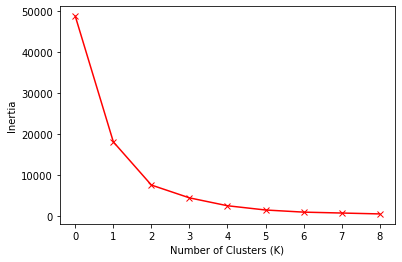

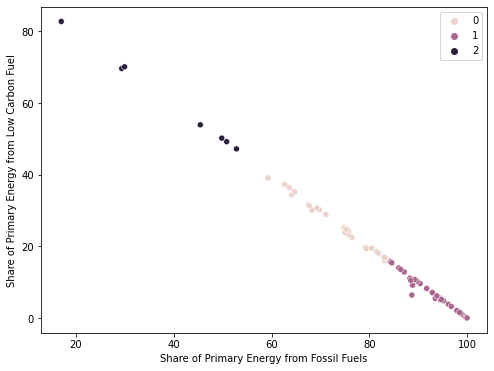

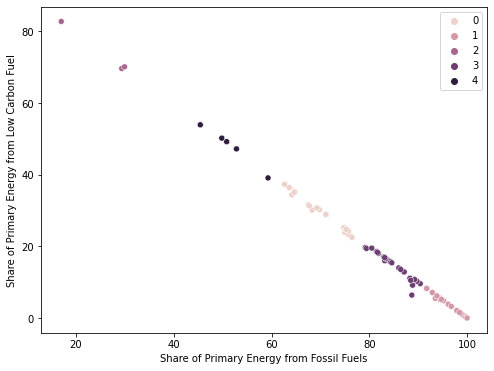

,fossil_share_energy,low_carbon_share_energy
0,73.809879,25.759121
1,93.523744,6.237233
2,39.294286,60.415857


In [63]:
# doing k means clustering on only fossil_share and low_carbon_share
# Use raw data and drop only rows with Nan value in our columns of interest. 

fossilshare = raw[['country','year','population','fossil_share_energy','low_carbon_share_energy']]
fossilshare = fossilshare.dropna()
fossilshare = fossilshare[fossilshare['year'] == 2020] # 91 countries
#fossilshare.reset_index(level=0, inplace=True)

#Determine index of rows to remove - those that are not countries. 
#country = fossilshare['country']
#index = pd.Index(country)
#print(index.get_indexer(['Africa', 'Asia Pacific', 'Europe', 'CIS', 'OECD', 'Non OECD', 'Eastern Africa', 'Middle Africa', 'Middle East','Western Africa', 'World']))

#fossilshare = fossilshare.drop([0, 3, 25, 12, 57, 21, 49, 50])
data = fossilshare[['fossil_share_energy','low_carbon_share_energy']]


#KMeans for k=1-10 to determine best value for K using elbow method. 
scores = [] #list to store the inertia values for several values of K

for ii in range(1,10):
    kmeans = KMeans(n_clusters=ii)
    kmeans.fit(data)
    scores.append(kmeans.inertia_)
    
#Plotting using elbow rule - inertia vs K.
plt.plot(scores, '-rx')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Kmeans with 2 clusters based on plot. 
kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(data)
cluster_centroids = pd.DataFrame(kmeans_2.cluster_centers_, columns=data.columns)
#fossilshare['Cluster'] = kmeans_2.predict(data[['fossil_share_energy','low_carbon_share_energy']])

# Plot the two-dimensional dataset following clustering 
cluster_labels = kmeans_2.labels_
fossilshare['cluster'] = cluster_labels.tolist()

#plt.figure(figsize=(8,6))
#sns.scatterplot(x=fossilshare['fossil_share_energy'], y=fossilshare['low_carbon_share_energy'], data=fossilshare, hue='cluster')
#plt.legend()
#plt.show()

# Kmeans with 3 clusters based on plot. 
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(data)
cluster_centroids = pd.DataFrame(kmeans_3.cluster_centers_, columns=data.columns)
#fossilshare['Cluster'] = kmeans_2.predict(data[['fossil_share_energy','low_carbon_share_energy']])

# Plot the two-dimensional dataset following clustering 
cluster_labels = kmeans_3.labels_
fossilshare['cluster'] = cluster_labels.tolist()

plt.figure(figsize=(8,6))
sns.scatterplot(x=fossilshare['fossil_share_energy'], y=fossilshare['low_carbon_share_energy'], data=fossilshare, hue='cluster')
plt.xlabel('Share of Primary Energy from Fossil Fuels')
plt.ylabel('Share of Primary Energy from Low Carbon Fuel')
plt.legend()
plt.show()

fossilshare.to_csv('/Users/rachelgodfrey/Documents/Northwestern/Quarter 3/DataSciencePipeline/ fossilshare.csv')

#score3 = silhouette_score(data, cluster_labels)
#print(score3)

# Kmeans with 5 clusters based on plot. 
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(data)
#cluster_centroids = pd.DataFrame(kmeans_5.cluster_centers_, columns=data.columns)

cluster_labels = kmeans_5.labels_
fossilshare['cluster_5'] = cluster_labels.tolist()

plt.figure(figsize=(8,6))
sns.scatterplot(x=fossilshare['fossil_share_energy'], y=fossilshare['low_carbon_share_energy'], data=fossilshare, hue='cluster_5')
plt.xlabel('Share of Primary Energy from Fossil Fuels')
plt.ylabel('Share of Primary Energy from Low Carbon Fuel')
plt.legend()
plt.show()

fossilshare.to_csv('/Users/rachelgodfrey/Documents/Northwestern/Quarter 3/DataSciencePipeline/ fossilshare.csv')

#score5 = silhouette_score(data, cluster_labels)
#print(score5)

cluster_centroids

In the plot above we carry out clustering using only fossil share and low carbon share. There is a clear and expected trend between fossil share and low carbon share. As fossil share increases, the low carbon share decreases. There are some points that sit very far from the clusters, which are potential outliers. Kmeans however is not good at identifying outliers, other algorithms can be used to over come this. 

From the above scatter plots, 3 clusters looks to make more sense than 2. As with only 2 clusters, there was a large range of values contained in cluster 0. However, cluster 2 and three are less defined. 

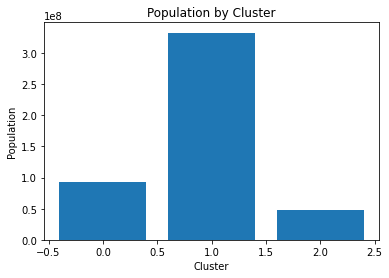

In [64]:
cluster_0 = fossilshare[fossilshare['cluster'] == 0]
cluster_0 = pd.DataFrame(cluster_0[['country','population']])
cluster_1 = fossilshare[fossilshare['cluster'] == 1]
cluster_1 = pd.DataFrame(cluster_1[['country','population']])
cluster_2 = fossilshare[fossilshare['cluster'] == 2]
cluster_2 = pd.DataFrame(cluster_2[['country','population']])
cluster_2.describe()


population = [9.307211e+07, 3.327407e+08, 4.743905e+07]
cluster = [0, 1, 2]

plt.bar(cluster, population)
plt.xlabel("Cluster")
plt.ylabel("Population")
plt.title("Population by Cluster")
plt.show()

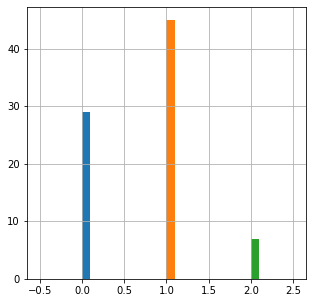

In [222]:
fossilshare[fossilshare['cluster'] == 0] # 29
fossilshare[fossilshare['cluster'] == 1] # 45
fossilshare[fossilshare['cluster'] == 2] # 7

clustergraph = fossilshare[['country', 'cluster']].groupby('cluster')
plot = clustergraph.cluster.hist(figsize=(5, 5))

In [22]:
cluster_0.to_csv('/Users/rachelgodfrey/Documents/Northwestern/Quarter 3/DataSciencePipeline/ cluster0.csv')
cluster_1.to_csv('/Users/rachelgodfrey/Documents/Northwestern/Quarter 3/DataSciencePipeline/ cluster1.csv')
cluster_2.to_csv('/Users/rachelgodfrey/Documents/Northwestern/Quarter 3/DataSciencePipeline/ cluster2.csv')

In [250]:
kmeans.cluster_centers_

array([[88.05091667, 11.63841667],
       [49.71075   , 50.118     ],
       [65.60354545, 33.77036364],
       [99.2235625 ,  0.772     ],
       [29.628     , 69.8495    ],
       [75.10245455, 24.52836364],
       [93.36116667,  6.09891667],
       [82.21958333, 17.5075    ],
       [16.961     , 82.74      ]])

Brazil, Finland, France, Iceland, Norway, Sweden, Switzerland There are significantly more countries to look at after dropping NaN values when looking at only Fossil Fuel Share and Renewable Energy Share. This time, the three clusters have %72.32, %92.42, and %39.29 fossil fuel usage. Most of the countries/areas are in cluster 2, with a very high percentage of fossil fuel usage.

## Clustering Using DB-SCAN

0.4664400189166793


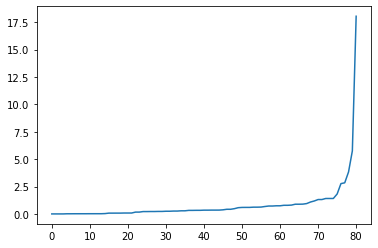

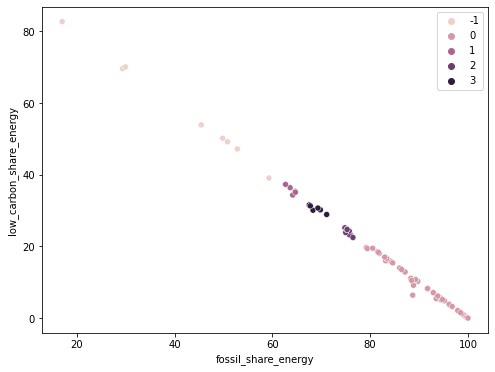

 0    52
 2    10
-1     8
 3     6
 1     5
Name: cluster_DBSCAN, dtype: int64


In [110]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Determine eps

X = fossilshare[['year', 'fossil_share_energy', 'low_carbon_share_energy']]
n = NearestNeighbors(n_neighbors=2)
n = n.fit(X)
dist,index = n.kneighbors(X)

distances = np.sort(dist, axis=0)
distances = distances[:,1]
plt.plot(distances)

#Use eps = 3

epsilon = 3.0 # Radial distance of 6 feet in km
model = DBSCAN(eps=epsilon, min_samples=5)
model.fit(fossilshare[['fossil_share_energy', 'low_carbon_share_energy']])

cluster_labels = model.labels_

fossilshare['cluster_DBSCAN'] = cluster_labels.tolist()

score = silhouette_score(X, cluster_labels)
print(score)

plt.figure(figsize=(8,6))
sns.scatterplot(x='fossil_share_energy', y='low_carbon_share_energy', data=fossilshare, hue='cluster_DBSCAN')
plt.legend()
plt.show()

print(fossilshare['cluster_DBSCAN'].value_counts())

## Random Forest for Feature Selection

In [115]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import warnings
warnings.simplefilter('ignore', UserWarning)

energyshare = raw[['country','year','gdp', 'population','electricity_generation','fossil_share_energy', 'coal_production', 'oil_production', 'gas_production']]
energyshare = energyshare.dropna()

y = energyshare[['fossil_share_energy']]
X = energyshare[['year','gdp', 'population','electricity_generation', 'coal_production', 'oil_production', 'gas_production']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rf1 = RandomForestRegressor()
RFdict = {'n_estimators':range(1,21), 'max_depth': range(1,21)}
grid = GridSearchCV(rf1, param_grid=RFdict, scoring='neg_mean_squared_error',cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 18, 'n_estimators': 19}


MSE: 12.447223964627062


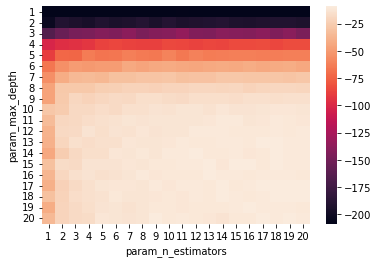

In [116]:
rf2 = RandomForestRegressor(n_estimators=18, max_depth=19)
# Evaluate the accuracy of the model using .score. Print the result below.
rf2.fit(X_train, y_train)
# You need to print the confusion matrix as well. First, get the predicted class
# Then use y_pred and y_test as inputs to confusion_matrix function to print the
y_pred2 = rf2.predict(X_test)
print('MSE:', mean_squared_error(y_test,y_pred2))

pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')

sns.heatmap(pvt)
plt.show()                     

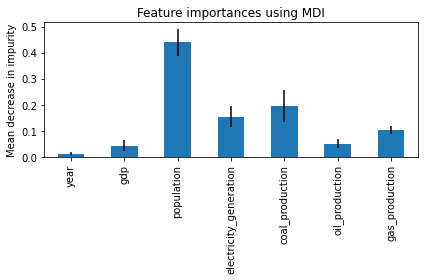

AxesSubplot(0.125,0.125;0.62x0.755)


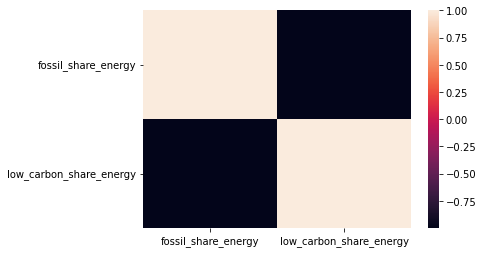

In [117]:
importances = rf2.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
stdev = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
forest_importances.plot.bar(yerr=stdev, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

corr_mat = sns.heatmap(data.corr())
print(corr_mat)